# Erdio: Testing Classifiers

Testing audio classifiers for Project Erdio, an urban environmental sound classifier.

Team members (no particular order): Matthew Frick, Matthew Heffernan, Paul Jredini, Jonathan Osborne, Joanne Dong  

Goal: Classify sounds for key stakeholders (see Stakeholder and KPI documentation).

In those notebook, I'll explore a variety of different classifiers, including Ensemble Learning, in the quest for an optimal classifier. I also investigate the power set to ensure we aren't throwing data at a wall and confusing ourselves.

### Remaining things to do:

- Tune the top candidates better and produce some plots

In [1]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Standard sklearn processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# sklearn Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

## The VotingClassifier
from sklearn.ensemble import VotingClassifier
# The Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier

## import accuracy metric
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define shortcuts for classifiers
names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA",
    "ExtraTrees",
    "Boosted RF"
]

# Collect classifiers into an iterable
## All the hyperparameters below can and should be investigated
classifiers = [
    make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    make_pipeline(StandardScaler(), KNeighborsClassifier(10,n_jobs=4)),
    make_pipeline(StandardScaler(), SVC(kernel="linear", C=0.025)),
    make_pipeline(StandardScaler(), SVC(gamma=2, C=1)),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=15)),
    make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4)),
    make_pipeline(StandardScaler(), MLPClassifier(alpha=0.01, max_iter=1000,early_stopping=True)),
    make_pipeline(StandardScaler(), AdaBoostClassifier()),
    make_pipeline(StandardScaler(), GaussianNB()),
    make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis()),
    make_pipeline(StandardScaler(), LinearDiscriminantAnalysis()),
    make_pipeline(StandardScaler(), ExtraTreesClassifier(n_estimators=500, max_depth=15)),
    make_pipeline(StandardScaler(), AdaBoostClassifier(RandomForestClassifier(max_depth=15, n_estimators=500,n_jobs=4))),
]

%matplotlib inline

## Setting up: Loading data, setting keys

In [2]:
# Keys for classifier 
classify_keys = ['crestfactor','harmonic_power','percussive_power','percussive_hits','harmonic_hits']

In [3]:
# Load data
#features_df = pd.read_csv('large_data/eq_with_harmony2.csv') # Old partial details
features_df = pd.read_csv('large_data/eq_harmony_combined.csv')
#features_df.dropna() # Drops NaN rows from our feature processing list
keys = list(features_df.keys())

In [20]:
use_all = True # Use all features to predict
if use_all:
    classify_keys = keys[1:-1] # don't include class or fold

In [22]:
classify_keys.remove('salience')

In [24]:
features_df.describe()

,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
count,7732.000000,7732.000000,7732.000000,7732.000000,7732.000000,7732.000000,7732.000000,7732.000000,7732.000000,7732.000000,...,7732.000000,7732.000000,7732.000000,7732.000000,7732.000000,7.732000e+03,7.732000e+03,7732.000000,7732.000000,7732.000000
mean,43.022745,46.495207,52.153118,54.881930,62.084174,66.125071,66.530550,67.419768,67.375583,64.949511,...,11.462260,8.913350,7.122022,7.676651,1.338593,2.565263e-03,3.256207e-04,228.589735,8.332256,5.371185
std,176.703567,136.634445,125.369831,116.421147,108.180386,100.336508,89.913139,88.670364,86.341888,80.649000,...,13.843459,10.893360,7.794862,4.594971,0.473262,1.406049e-02,1.925023e-03,252.334626,15.219344,2.843176
min,0.000432,0.000540,0.000594,0.000631,0.001056,0.001074,0.001088,0.001651,0.002765,0.004346,...,0.020673,0.016762,0.014721,1.182664,1.000000,6.659914e-14,3.317685e-10,0.000000,0.000000,1.000000
25%,1.822219,2.427433,3.154214,3.951474,5.685361,7.405419,8.839198,10.447118,11.793331,12.633812,...,3.266331,2.497383,2.085227,4.969632,1.000000,4.320456e-06,6.010279e-07,48.978612,1.000000,3.000000
50%,7.021452,9.146109,11.815302,14.114159,21.751311,27.243246,32.488573,34.854983,38.513382,38.477670,...,7.277380,5.562813,4.760455,6.520001,1.000000,2.636459e-05,1.420699e-06,142.271870,2.000000,5.000000
75%,26.350054,35.357184,43.092715,49.437613,66.702473,81.095333,86.521367,87.974056,87.461882,85.545922,...,14.256337,11.169525,9.553031,9.083698,2.000000,3.230638e-04,1.177675e-05,313.098490,7.000000,8.000000
max,3546.550091,2167.821913,1556.984098,1364.750299,1192.576708,1011.511983,963.127206,1032.481591,887.508786,847.766325,...,116.073719,96.531130,87.146006,78.221700,2.000000,6.049485e-01,4.137904e-02,2542.986702,86.000000,10.000000


In [25]:
features_df.head()

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
2,street_music,3.980402,5.639204,8.452841,13.437525,19.415338,35.319351,61.852247,62.117064,69.794119,...,4.442734,3.375018,3.069331,7.897027,1,0.000030,6.712090e-05,332.313043,4,7
3,engine_idling,49.217855,118.563553,413.636333,356.165592,298.137279,250.708116,187.251374,154.515099,123.041750,...,7.791927,5.879618,5.338780,2.837097,1,0.013045,2.409356e-07,132.342029,16,10
4,jackhammer,32.283071,64.291137,87.047839,95.002994,83.547205,78.752242,62.357059,56.717538,47.499636,...,6.121235,4.655034,3.885653,7.351516,1,0.000003,7.250180e-07,77.518617,64,1
5,engine_idling,8.848471,11.130128,10.380974,9.584670,10.101372,12.845699,21.601185,36.468534,35.321569,...,1.566303,1.181698,0.988505,3.722183,1,0.001770,3.998450e-07,1067.550532,0,9
7,drilling,15.700406,13.609655,10.262346,8.286569,6.292002,5.021286,4.564815,4.215959,4.250508,...,20.899897,17.508719,14.861140,4.940376,1,0.000489,7.032312e-07,161.944149,0,2


In [26]:
# What if we drop children playing?
features_df = features_df[features_df['class'] != 'children_playing']

In [27]:
# Try grouping sounds into families since jackhammers/drills are hard to differentiate between and 
# crowd noises drown out children playing and street music

#features_df['family'] = features_df['class'].replace({'air_conditioner':5, 'car_horn':1, 'children_playing':0, 'dog_bark':3, 'drilling':4, 'engine_idling':5, 'gun_shot':6, 'jackhammer':4, 'siren':8, 'street_music':0},inplace=False)

In [28]:
# Searching for NaNs in input
np.where(np.isnan(features_df[classify_keys].values) == 1)

(array([], dtype=int64), array([], dtype=int64))

Now that we've loaded the data, I'll drop a fold as recommended by the documentation.

In [29]:
dropfold = 1

cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)

In [30]:
cv_features_df.head()

,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,...,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold
2,street_music,3.980402,5.639204,8.452841,13.437525,19.415338,35.319351,61.852247,62.117064,69.794119,...,4.442734,3.375018,3.069331,7.897027,1,0.000030,6.712090e-05,332.313043,4,7
3,engine_idling,49.217855,118.563553,413.636333,356.165592,298.137279,250.708116,187.251374,154.515099,123.041750,...,7.791927,5.879618,5.338780,2.837097,1,0.013045,2.409356e-07,132.342029,16,10
5,engine_idling,8.848471,11.130128,10.380974,9.584670,10.101372,12.845699,21.601185,36.468534,35.321569,...,1.566303,1.181698,0.988505,3.722183,1,0.001770,3.998450e-07,1067.550532,0,9
7,drilling,15.700406,13.609655,10.262346,8.286569,6.292002,5.021286,4.564815,4.215959,4.250508,...,20.899897,17.508719,14.861140,4.940376,1,0.000489,7.032312e-07,161.944149,0,2
8,jackhammer,15.457212,9.107619,8.688648,7.658117,9.039835,8.061542,8.755220,10.832037,11.061374,...,16.451793,12.660217,11.504940,11.322416,1,0.000095,1.132678e-05,41.947826,69,5


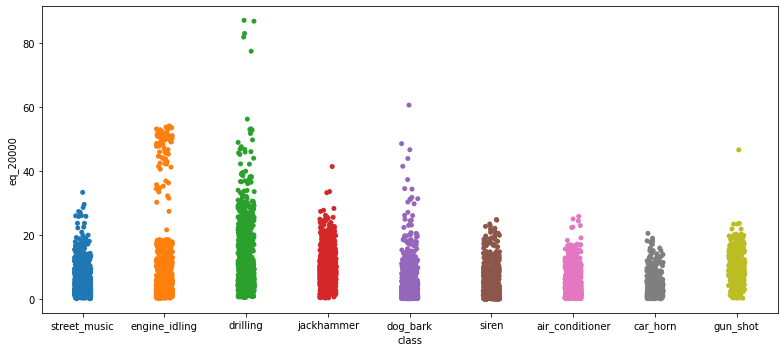

In [31]:
plt.figure(figsize=(11,5))
sns.stripplot(data = cv_features_df,
             x = 'class',
             y = 'eq_20000')
plt.tight_layout()
plt.show()

In [32]:
def reduce_confmat(matrix):
    """
    Takes the N-dimensional confusion matrix as input and returns 
    a tuple (true positive, false positive, false negative) for the whole set.
    
    confusion matrix C is such that C_ij is equal to the 
    number of observations known to be in group i 
    and predicted to be in group j.
    """
    
    tps = [] # True positives for each axis
    fps = [] # True 
    fns = []
    
    for i in range(len(matrix)):
        
        tps.append(matrix[i,i]) # Append true positives for a class
        #confusion_matrix(pred,y_test)[0,:] # returns row 0
        #confusion_matrix(pred,y_test)[:,0] # returns column 0
        fps.append( np.delete(matrix[:,i],i).sum() ) # take sum, dropping the diagonal element
        fns.append( np.delete(matrix[i,:],i).sum() ) # take sum, dropping the diagonal element
        
    res = (tps, fps, fns)
    return res

In [33]:
def TPR(prediction, data):
    """
    Returns True Positive Ratio given a prediction and data
    """
    confmat = confusion_matrix(prediction, data)
#     print(confmat)
#     plt.figure()
#     ConfusionMatrixDisplay(confmat)
#     plt.show()
#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    
    (TP, FP, FN) = reduce_confmat(confmat)
    
    truepos = lambda a, b, c: a/(b+c)
    
    return np.mean([truepos(TP[i], TP[i], FN[i]) for i in range(len(TP))])
    

    

In [34]:
def recall(prediction, data):
    """
    Calculates recall of a prediction
    """
    
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    (TP, FP, FN) = reduce_confmat(confmat)
    
    rec = lambda a, b, c: a/(b+c)
    
    return np.mean([rec(TP[i], TP[i], FN[i]) for i in range(len(TP))])
    

def precision(prediction, data):
    """
    Calculates precision of a prediction
    """
    
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    (TP, FP, FN) = reduce_confmat(confmat)
    
    prec = lambda a, b, c: a/(b+c)
    
    return np.mean([prec(TP[i], TP[i], FP[i]) for i in range(len(TP))])
    

In [35]:
def Fmeasure(prediction, data):
    """
    Returns Fmeasure. 
    
    This is considered a balance of the precision and the recall.
    
    F = (2*P*R)/(P+R)
    
    where
    
    P = TP/(TP + FP) is the precision and
    R = TP/(TP + FN) is the recall.
    
    Reference: 
    Müller, Meinard. Fundamentals of music processing: Audio, analysis, algorithms, applications. 
    Vol. 5. Cham: Springer, 2015.
    Sec. 4.5 pp. 217
    """
    confmat = confusion_matrix(prediction, data)

#     TN = confmat[0,0]
#     FP = confmat[0,1]
#     FN = confmat[1,0]
#     TP = confmat[1,1]
    
    (TP, FP, FN) = reduce_confmat(confmat)
    
#     P = TP/(TP + FP)
#     R = TP/(TP + FN)
    
    workhorse = lambda a, b, c: a/(b+c)
    Fmeas = lambda x,y : (2*x*y)/(x+y)
    
    P = [workhorse(TP[i], TP[i], FP[i]) for i in range(len(TP))]
    R = [workhorse(TP[i], TP[i], FN[i]) for i in range(len(TP))]
    
    
    #F = (2*P*R)/(P + R)
    return np.average([Fmeas(P[i],R[i]) for i in range(len(P))]) #F
    

## Establishing a baseline: The Random Forest

In [36]:
forest = RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=4) 

In [37]:
if len(classify_keys) == 1:
    X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
else:
    X_train = cv_features_df[classify_keys].values
    
y_train = cv_features_df['family'].values

X_test = validation_features_df[classify_keys].values
y_test = validation_features_df['family']

KeyError: 'family'

In [127]:
set(np.where(np.isnan(X_train) == 1)[0])

set()

In [128]:
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=4)

In [129]:
pred = forest.predict(X_test)

In [130]:
accuracy_score(pred,y_test)

0.6688227684346701

In [131]:
forest.feature_importances_

array([0.03074615, 0.03160271, 0.02985037, 0.03145312, 0.03515415,
       0.03284496, 0.0320296 , 0.03233284, 0.0378898 , 0.04010964,
       0.03062583, 0.03147822, 0.02565869, 0.02715677, 0.02995894,
       0.02626621, 0.02155936, 0.02051765, 0.02189752, 0.02696454,
       0.0359346 , 0.0381327 , 0.03370578, 0.05568201, 0.0299029 ,
       0.05827643, 0.06595203, 0.05129086, 0.03502561])

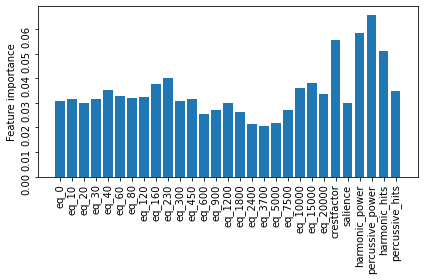

In [132]:
fig = plt.figure()
ax0 = fig.add_subplot(111)

ax0.bar(classify_keys,forest.feature_importances_)

# alternatively
ax0.tick_params(rotation=90)
ax0.set_ylabel('Feature importance')

plt.tight_layout()
plt.show()

In [133]:
#classlabels = {'air_conditioner':0, 'car_horn':1, 'children_playing':2, 'dog_bark':3, 'drilling':4, 'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9}.keys()
classlabels = {'air_conditioner':0, 'car_horn':1, 'dog_bark':3, 'drilling':4, 'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, 'street_music':9}.keys()


#familylabels = {'house_sounds':0, 'car_horn':1, 'dog_bark':3, 'drilling':4, 'engine_idling':5, 'gun_shot':6, 'jackhammer':7, 'siren':8, }.keys()

familylabels = {'house_sounds':0, 'car_horn':1, 'dog_bark':3, 'construction':4, 'motors':5, 'gun_shot':6, 'siren':8}.keys()

In [134]:
TPR(pred,y_test)

0.67491068444163

In [135]:
confusion_matrix(pred,y_test)

array([[ 61,  10,   7,   1,  52,   1,   3],
       [  1,  17,   1,   1,   1,   0,   1],
       [  0,   0,  76,   8,   4,   9,   3],
       [ 28,   4,   4, 194,  33,   6,   4],
       [  7,   2,   6,  13,  91,   0,  10],
       [  0,   0,   2,   2,   2,  19,   6],
       [  3,   3,   4,   1,  13,   0,  59]])

<Figure size 648x648 with 0 Axes>

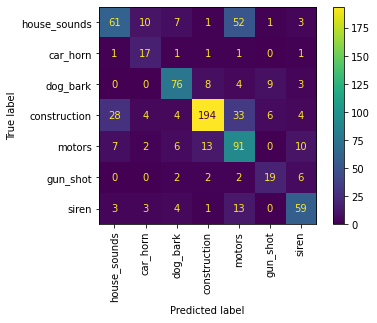

In [136]:
plt.figure(figsize=(9,9))
disp = ConfusionMatrixDisplay(confusion_matrix(pred,y_test),display_labels=familylabels)
disp.plot(xticks_rotation='vertical')
plt.show()

### Trying another model: A simple NN

In [137]:
mlp = MLPClassifier(alpha=0.1, max_iter=5000,early_stopping=True)

In [138]:
mlp.fit(X_train, y_train)

MLPClassifier(alpha=0.1, early_stopping=True, max_iter=5000)

In [139]:
pred_mlp = mlp.predict(X_test)

In [140]:
accuracy_score(pred_mlp,y_test)

0.6377749029754204

In [141]:
TPR(pred_mlp,y_test)

0.5800741499695274

## Looping through specified models

In [142]:
for i, classifier in enumerate(classifiers):

    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    print(f'{names[i]} Classifier accuracy score: {accuracy_score(y_test, pred)}')
    print(f'{names[i]} Classifier Precision: {precision(y_test, pred)}')
    print(f'{names[i]} Classifier Recall: {recall(y_test, pred)}')
    print(f'{names[i]} Classifier Fmeasure: {Fmeasure(y_test, pred)}')
    print("")

Logistic Regression Classifier accuracy score: 0.702457956015524
Logistic Regression Classifier Precision: 0.6670914079106735
Logistic Regression Classifier Recall: 0.6473179075314813
Logistic Regression Classifier Fmeasure: 0.6525652545429118

Nearest Neighbors Classifier accuracy score: 0.5976714100905562
Nearest Neighbors Classifier Precision: 0.5647883861003357
Nearest Neighbors Classifier Recall: 0.5550042358632771
Nearest Neighbors Classifier Fmeasure: 0.5561407735570797

Linear SVM Classifier accuracy score: 0.6752910737386805
Linear SVM Classifier Precision: 0.6366072408297823
Linear SVM Classifier Recall: 0.5882836912072793
Linear SVM Classifier Fmeasure: 0.5996039673633992

RBF SVM Classifier accuracy score: 0.49288486416558863
RBF SVM Classifier Precision: 0.5375038493363979
RBF SVM Classifier Recall: 0.3969984474208489
RBF SVM Classifier Fmeasure: nan



<ipython-input-111-bf842f1e60e5>:32: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)


Decision Tree Classifier accuracy score: 0.5588615782664942
Decision Tree Classifier Precision: 0.5068433819741421
Decision Tree Classifier Recall: 0.5158513331840338
Decision Tree Classifier Fmeasure: 0.5019595020859213

Random Forest Classifier accuracy score: 0.666235446313066
Random Forest Classifier Precision: 0.6828367839424053
Random Forest Classifier Recall: 0.6334066202742045
Random Forest Classifier Fmeasure: 0.6470212693058397

Neural Net Classifier accuracy score: 0.7011642949547219
Neural Net Classifier Precision: 0.6752138330441317
Neural Net Classifier Recall: 0.6601396636375279
Neural Net Classifier Fmeasure: 0.6648983337930232

AdaBoost Classifier accuracy score: 0.46183699870633893
AdaBoost Classifier Precision: 0.536430473781142
AdaBoost Classifier Recall: 0.4585229609814327
AdaBoost Classifier Fmeasure: 0.453974287441712

Naive Bayes Classifier accuracy score: 0.4087968952134541
Naive Bayes Classifier Precision: 0.45995013645650434
Naive Bayes Classifier Recall: 0.4

In [60]:
# Let's investigate the Logistic Regression, because what is happening there.

NameError: name 'nb_' is not defined

## Trying out a Voting Classifier to beat the others

In [61]:
voter_list = [(names[i], classifiers[i]) for i in range(len(names))]

In [62]:
voting = VotingClassifier(voter_list,
                         voting='hard')

In [63]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression(max_iter=1000))])),
                             ('Nearest Neighbors',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('kneighborsclassifier',
                                               KNeighborsClassifier(n_jobs=4,
                                                                    n_neighbors=10))])),
                             ('Linear SVM',
                              Pipeline(steps=[('standardsc...
                                               LinearDiscriminantAnalysis())])),
                             ('ExtraTrees',
          

In [64]:
vpred = voting.predict(X_test)


In [65]:
accuracy_score(y_test,vpred)

0.5521191294387171

In [66]:
TPR(y_test,vpred)

0.730117760651974

In [67]:
precision(y_test,vpred)

0.596111073142656

In [68]:
recall(y_test,vpred)

0.53525023071244

In [69]:
Fmeasure(y_test,vpred)

0.5475586001934875

Notably, the Voting Classifier doesn't always improve things. 

## Considering all folds in validation

In [32]:
len(names)

13

In [33]:
accuracies = np.zeros((10, len(names)))
TPRs = np.zeros((10,len(names)))
Fs = np.zeros((10,len(names)))
recalls = np.zeros((10,len(names)))
precisions = np.zeros((10,len(names)))

In [34]:
for dfi in range(0,10):
    dropfold = dfi + 1
    cv_features_df = features_df.drop(features_df[features_df['fold']==dropfold].index)
    validation_features_df = features_df.drop(features_df[features_df['fold']!=dropfold].index)

    if len(classify_keys) == 1:
        X_train = cv_features_df[classify_keys[0]].values.reshape(-1,1)
    else:
        X_train = cv_features_df[classify_keys].values

    y_train = cv_features_df['class'].values

    X_test = validation_features_df[classify_keys].values
    y_test = validation_features_df['class']

    for i, classifier in enumerate(classifiers):
        print(dfi, i)
        classifier.fit(X_train, y_train)
        pred = classifier.predict(X_test)
        
        accuracies[dfi][i] = accuracy_score(y_test, pred)
        TPRs[dfi][i] = TPR(y_test, pred)
        Fs[dfi][i] = Fmeasure(y_test, pred)
        recalls[dfi][i] = recall(y_test, pred)
        precisions[dfi][i] = precision(y_test, pred)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
7 0
7 1
7 2
7 3


<ipython-input-13-bf842f1e60e5>:32: RuntimeWarning: invalid value encountered in double_scalars
  Fmeas = lambda x,y : (2*x*y)/(x+y)


7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12


In [35]:
TPRs_final = np.mean(TPRs,axis=0)
accuracies_final = np.mean(accuracies,axis=0)
Fs_final = np.mean(Fs,axis=0)
recalls_final = np.mean(recalls,axis=0)
precisions_final = np.mean(precisions,axis=0)

In [36]:
for i,name in enumerate(names):
    print(f'{name} accuracy: {accuracies_final[i]}')

Logistic Regression accuracy: 0.5425496112025389
Nearest Neighbors accuracy: 0.4514205223731942
Linear SVM accuracy: 0.4827354771887668
RBF SVM accuracy: 0.39589141480566764
Decision Tree accuracy: 0.4139801900471256
Random Forest accuracy: 0.5421407705422256
Neural Net accuracy: 0.5610780074115181
AdaBoost accuracy: 0.3915390529956718
Naive Bayes accuracy: 0.3234899760812644
QDA accuracy: 0.466816725386908
LDA accuracy: 0.46016797941904547
ExtraTrees accuracy: 0.4909148128133312
Boosted RF accuracy: 0.544672786804426


In [37]:
for i,name in enumerate(names):
    print(f'{name} TPR: {TPRs_final[i]}')

Logistic Regression TPR: 0.5378700435458591
Nearest Neighbors TPR: 0.46048357175783794
Linear SVM TPR: 0.47226842015612247
RBF SVM TPR: 0.3742313724017198
Decision Tree TPR: 0.4245740986076486
Random Forest TPR: 0.5445354276874319
Neural Net TPR: 0.5670828426362703
AdaBoost TPR: 0.39989120926766153
Naive Bayes TPR: 0.3217824543596647
QDA TPR: 0.46828793197839846
LDA TPR: 0.44688797892932197
ExtraTrees TPR: 0.4799060151258794
Boosted RF TPR: 0.5479338566229124


In [38]:
for i,name in enumerate(names):
    print(f'{name} Fmeasure: {Fs_final[i]}')

Logistic Regression Fmeasure: 0.5355785299768603
Nearest Neighbors Fmeasure: 0.45391351784471984
Linear SVM Fmeasure: 0.47217333734270844
RBF SVM Fmeasure: nan
Decision Tree Fmeasure: 0.41428880691418046
Random Forest Fmeasure: 0.5389281492298815
Neural Net Fmeasure: 0.5598119755456575
AdaBoost Fmeasure: 0.3786211682428176
Naive Bayes Fmeasure: 0.30238820847647674
QDA Fmeasure: 0.47298664355691
LDA Fmeasure: 0.45368748461266434
ExtraTrees Fmeasure: 0.47211375219155727
Boosted RF Fmeasure: 0.5423479225584578


In [39]:
for i,name in enumerate(names):
    print(f'{name} recall: {recalls_final[i]}')

Logistic Regression recall: 0.5378700435458591
Nearest Neighbors recall: 0.46048357175783794
Linear SVM recall: 0.47226842015612247
RBF SVM recall: 0.3742313724017198
Decision Tree recall: 0.4245740986076486
Random Forest recall: 0.5445354276874319
Neural Net recall: 0.5670828426362703
AdaBoost recall: 0.39989120926766153
Naive Bayes recall: 0.3217824543596647
QDA recall: 0.46828793197839846
LDA recall: 0.44688797892932197
ExtraTrees recall: 0.4799060151258794
Boosted RF recall: 0.5479338566229124


In [40]:
for i,name in enumerate(names):
    print(f'{name} precision: {precisions_final[i]}')

Logistic Regression precision: 0.5709708848898587
Nearest Neighbors precision: 0.46428290835212965
Linear SVM precision: 0.5355037897732108
RBF SVM precision: 0.4672654970562576
Decision Tree precision: 0.41988513552000245
Random Forest precision: 0.5568981762268274
Neural Net precision: 0.5758761852603016
AdaBoost precision: 0.39299912193524494
Naive Bayes precision: 0.41589962085115967
QDA precision: 0.5241336336337945
LDA precision: 0.5271520612050247
ExtraTrees precision: 0.49774286211331714
Boosted RF precision: 0.5635709060978755


## Now: Tune the best models

Now that a preliminary search of the classifier space has given us a ranking of classifiers, we can focus the search on a more limited number of methods. We can then tune these hyperparameters for optimal performance.

Preliminary model ranking:
   1. Random Forest (Boosted is comparable)
   2. Neural Net
   3. Naive Bayes